In [34]:
import db_logger
import matplotlib.pyplot as plt
import glob, pathlib
import ipywidgets as widgets
%load_ext autoreload
%autoreload 2

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:

logger =  db_logger.DB_Logger("/mnt/data/arty/data/gan_sampling/baseline.db", connect_only=True)
name2id = {}
for id in logger.get_experiment_ids():
    name = logger.get_experiment_name(id)
    name2id[name] = id
    print(name) 
    # if "rlvl2" in name:
    #     logger.remove_experiment(id)

Connecting to existing database at /mnt/data/arty/data/gan_sampling/baseline.db
PathMNIST_rlvlNone_bTrue_aug_True
BloodMNIST_rlvl3_bTrue_aug_True
OrganCMNIST_rlvl3_bTrue_aug_True
BloodMNIST_rlvl3_bTrue_aug_False
BloodMNIST_rlvl1_bTrue_aug_True
PathMNIST_rlvlNone_bTrue_aug_False
BloodMNIST_rlvl2_bTrue_aug_False
PathMNIST_rlvl2_bFalse_aug_False
BloodMNIST_rlvl2_bTrue_aug_True


/tmp/ipykernel_2596356/696975736.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1, 1, figsize=(10, 8))


interactive(children=(Dropdown(description='exp1', options=('BloodMNIST_rlvl1_bFalse_aug_False', 'BloodMNIST_r…

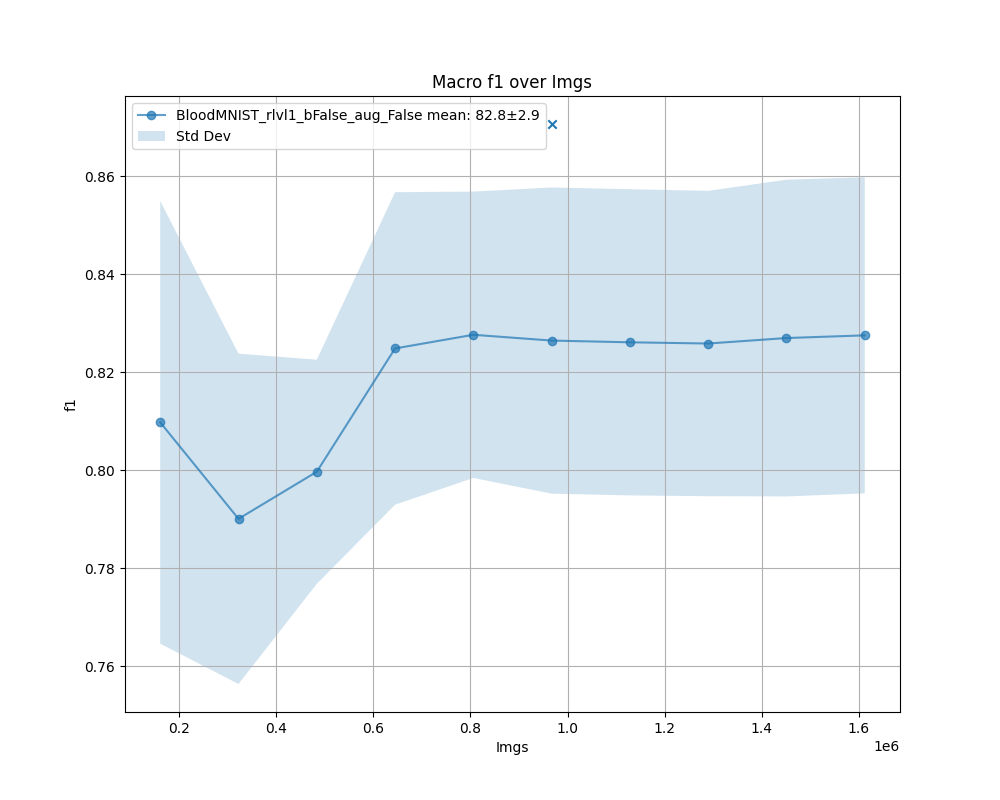

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
names = sorted([logger.get_experiment_name(x) for x in logger.get_experiment_ids()],)
@widgets.interact(
        exp1=names, 
        exp2=["none"]+names, 
        exp3=["none"]+names,
        exp4=["none"]+names,
        metric=["f1", "acc", "precision", "recall"])
def display_content(exp1, exp2, exp3, exp4, metric):
    name2id = {}
    for id in logger.get_experiment_ids():
        name2id[logger.get_experiment_name(id)] = id
    print(f"Working ...", end="")
    ax.clear()
    db_logger.plot_metric(logger, [name2id[exp1]], metric=metric, ax=ax, prefix='')
    if exp2 != "none":
        db_logger.plot_metric(logger, [name2id[exp2]], metric=metric, ax=ax, prefix='')
    if exp3 != "none":
        db_logger.plot_metric(logger, [name2id[exp3]], metric=metric, ax=ax, prefix='')
    if exp4 != "none":
        db_logger.plot_metric(logger, [name2id[exp4]], metric=metric, ax=ax, prefix='')
    print(f"\rDone       ")